In [25]:
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from ultralytics import YOLO


In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from ultralytics import YOLO

# Load YOLOv10 model
model_yolo = YOLO("yolov10s.pt")

# Define character recognition model
model_char = Sequential()
model_char.add(Input(shape=(28, 28, 3)))  # Use Input() to avoid warning

model_char.add(Conv2D(16, (22, 22), activation='relu', padding='same'))
model_char.add(Conv2D(32, (16, 16), activation='relu', padding='same'))
model_char.add(Conv2D(64, (8, 8), activation='relu', padding='same'))
model_char.add(Conv2D(64, (4, 4), activation='relu', padding='same'))

model_char.add(MaxPooling2D(pool_size=(4, 4)))
model_char.add(Dropout(0.4))
model_char.add(Flatten())
model_char.add(Dense(128, activation='relu'))
model_char.add(Dense(36, activation='softmax'))

# Optional: Load pre-trained weights if available
# model_char.load_weights("checkpoints/my_checkpoint")


In [27]:
char_map = {i: ch for i, ch in enumerate('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}

def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def predict_characters(char_list):
    output = []
    for ch in char_list:
        img = cv2.resize(ch, (28,28))
        img = fix_dimension(img)
        img = img.reshape(1,28,28,3)
        y_ = model_char.predict(img)
        character = char_map[np.argmax(y_)]
        output.append(character)
    return ''.join(output)


In [28]:
def detect_and_read_plate(image_path):
    results = model_yolo(image_path)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    image = cv2.imread(image_path)
    plate_img = None
    for box in boxes:
        x1, y1, x2, y2 = box[:4]
        plate_img = image[y1:y2, x1:x2]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Detected License Plate")
    plt.axis('off')
    plt.show()
    return plate_img


In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Prepare data from your class folders
data = []
labels = []

data_dir = r"E:\ML Projects\number plate detection\data\train"
classes = sorted(os.listdir(data_dir))  # class_0, class_A, ..., class_Z

label_map = {cls: idx for idx, cls in enumerate(classes)}

# Read images and assign labels
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for img_name in os.listdir(cls_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = load_img(img_path, color_mode="grayscale", target_size=(28, 28))
                img = img_to_array(img) / 255.0
                data.append(img)
                labels.append(label_map[cls])
            except:
                continue

data = np.array(data)
labels = to_categorical(labels, num_classes=len(label_map))

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model_char = Sequential()
model_char.add(Input(shape=(28, 28, 1)))  # ✅ Preferred way to specify input shape

model_char.add(Conv2D(32, (3, 3), activation='relu'))
model_char.add(MaxPooling2D((2, 2)))
model_char.add(Conv2D(64, (3, 3), activation='relu'))
model_char.add(MaxPooling2D((2, 2)))
model_char.add(Flatten())
model_char.add(Dense(128, activation='relu'))
model_char.add(Dropout(0.5))
model_char.add(Dense(len(label_map), activation='softmax'))

model_char.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_char.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4822 - loss: 2.7962 - val_accuracy: 0.4624 - val_loss: 2.5494
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5310 - loss: 2.2742 - val_accuracy: 0.4624 - val_loss: 2.0111
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4736 - loss: 1.9543 - val_accuracy: 0.4538 - val_loss: 1.5163
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4792 - loss: 1.5529 - val_accuracy: 0.4335 - val_loss: 1.2840
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5100 - loss: 1.2888 - val_accuracy: 0.4509 - val_loss: 1.2213
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5113 - loss: 1.1709 - val_accuracy: 0.3786 - val_loss: 1.1055
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4914 - loss: 1.1541 - val_accuracy: 0.4480 - val_loss: 1.1882
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5118 - loss: 1.0870 - val_accuracy: 0.3873 - v

In [31]:
reverse_map = {v: k.replace("class_", "") for k, v in label_map.items()}



image 1/1 E:\ML Projects\number plate detection\image1.png: 384x640 1 car, 1 motorcycle, 1 bus, 282.7ms
Speed: 4.8ms preprocess, 282.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

🔍 Processing Image: E:\ML Projects\number plate detection\image1.png
Class          Confidence     Coordinates (x1, y1, x2, y2)
car            0.92           (21, 0, 309, 181)


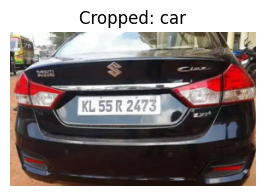

bus            0.81           (0, 2, 49, 45)


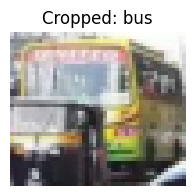

motorcycle     0.52           (282, 13, 312, 63)


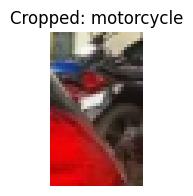

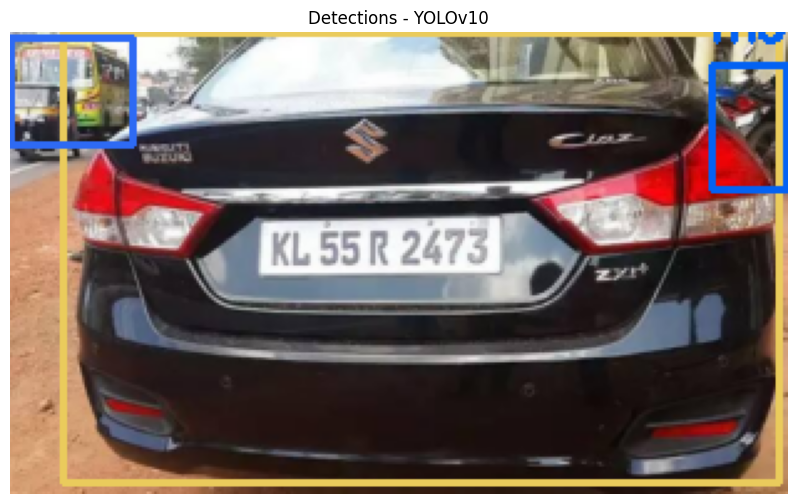


✅ Output saved to: E:\ML Projects\number plate detection\output\detected_image.png


In [32]:
from ultralytics import YOLO
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

# Load YOLOv10 model
model_path = r"E:\ML Projects\number plate detection\yolov10s.pt"
model = YOLO(model_path)

# Class names (YOLOv10 pre-trained COCO or custom)
class_names = model.names  # Automatically gets class names from the model

# Input image
input_path = r"E:\ML Projects\number plate detection\image1.png"
image = cv2.imread(input_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(source=input_path, show=False, conf=0.25)

# Set up colors for each class
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype='uint8')

# Console output header
print(f"\n🔍 Processing Image: {input_path}")
print(f"{'Class':<15}{'Confidence':<15}{'Coordinates (x1, y1, x2, y2)'}")

# Process results
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        label = class_names[cls]

        # Console output per detection
        print(f"{label:<15}{conf:<15.2f}({x1}, {y1}, {x2}, {y2})")

        # Bounding box color
        color = tuple(int(c) for c in colors[cls])

        # Draw bounding box and label
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image_rgb, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Crop and show detected license plate area (optional)
        cropped_plate = image[y1:y2, x1:x2]
        if cropped_plate.size > 0:
            cropped_rgb = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4, 2))
            plt.imshow(cropped_rgb)
            plt.axis('off')
            plt.title(f"Cropped: {label}")
            plt.show()

# Show full image with all detections
plt.figure(figsize=(12, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Detections - YOLOv10")
plt.show()

# Optional: Save output image
output_path = r"E:\ML Projects\number plate detection\output\detected_image.png"
cv2.imwrite(output_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
print(f"\n✅ Output saved to: {output_path}")


In [33]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [34]:
import pytesseract
import cv2

img = cv2.imread(r"E:\ML Projects\number plate detection\image1.png")
text = pytesseract.image_to_string(img)
print("Detected text:", text)


Detected text: 


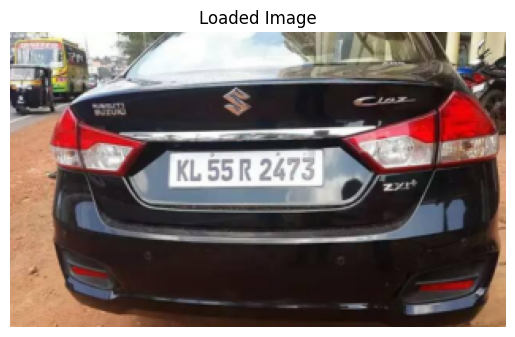

In [35]:
import cv2
import matplotlib.pyplot as plt

# Read image from path (⚠️ use raw string or double backslashes)
img_path = r"E:\ML Projects\number plate detection\image1.png"
img_bgr = cv2.imread(img_path)

# Check if image was loaded
if img_bgr is None:
    print("❌ Error: Could not read the image. Check the path.")
else:
    # Convert from BGR (OpenCV) to RGB (matplotlib expects RGB)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Loaded Image")
    plt.show()



0: 384x640 1 car, 1 motorcycle, 1 bus, 216.2ms
Speed: 3.0ms preprocess, 216.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
[✅ Plate]:  | Saved to: saved_plates/_20250622_084847.jpg
[✅ Plate]:  | Saved to: saved_plates/_20250622_084848.jpg
[✅ Plate]:  | Saved to: saved_plates/_20250622_084848.jpg


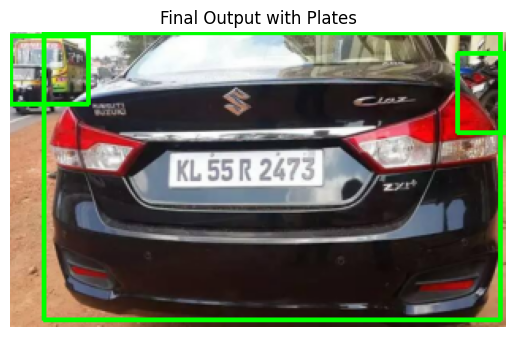

In [36]:
# Combined YOLOv10 + Tesseract OCR License Plate Detection Code (Static Image Version)

import cv2
import os
import pytesseract
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Set Tesseract path (adjust if needed)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Define paths
yolo_model_path = r"E:\ML Projects\number plate detection\yolov10s.pt"
image_path = r"E:\ML Projects\number plate detection\image1.png"

# Load YOLOv10 model
yolo_model = YOLO(yolo_model_path)

# Load input image
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Run YOLOv10 detection
results = yolo_model(img_bgr, conf=0.4)[0]

# Create folder to save cropped plates
os.makedirs("saved_plates", exist_ok=True)

# Process each detection
for box in results.boxes.data:
    x1, y1, x2, y2, conf, cls = map(int, box[:6])
    plate_img = img_bgr[y1:y2, x1:x2]

    if plate_img.size == 0:
        continue

    # Preprocess for OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    _, thresh = cv2.threshold(resized, 120, 255, cv2.THRESH_BINARY)
    pil_img = Image.fromarray(thresh)

    # OCR using Tesseract
    config = '--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    plate_text = pytesseract.image_to_string(pil_img, config=config).strip()

    # Draw results on image
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_bgr, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Save cropped plate image
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_path = f"saved_plates/{plate_text}_{timestamp}.jpg"
    cv2.imwrite(save_path, plate_img)
    print(f"[✅ Plate]: {plate_text} | Saved to: {save_path}")

# Show final image
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Final Output with Plates")
plt.show()


In [37]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,1))
    new_img[:,:,0] = img
    return new_img

def show_results():
    output = []
    for ch_img in char:  # char[] must be filled by segment_characters()
        # Resize and reshape each character
        img_ = cv2.resize(ch_img, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_).reshape(1,28,28,1) / 255.0

        # Predict class index
        prediction = model_char.predict(img, verbose=0)
        class_idx = np.argmax(prediction)

        # Convert index back to actual character
        character = reverse_map[class_idx]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number


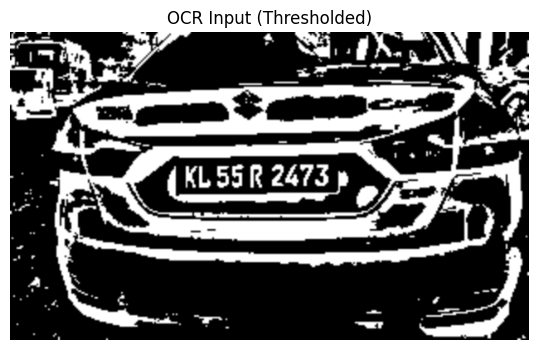

In [42]:
import cv2
import pytesseract
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# ✅ Corrected path using raw string
image_path = r"E:\ML Projects\number plate detection\image1.png"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold
thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 35, 15
)

# Resize for better OCR
resized = cv2.resize(thresh, (0, 0), fx=2, fy=2)

# OCR
custom_config = r'--oem 3 --psm 7'
text = pytesseract.image_to_string(resized, config=custom_config)
cleaned_text = text.strip().replace("\n", "").replace(" ", "")

# Display image
plt.figure(figsize=(10, 4))
plt.imshow(resized, cmap='gray')
plt.title("OCR Input (Thresholded)")
plt.axis('off')
plt.show()


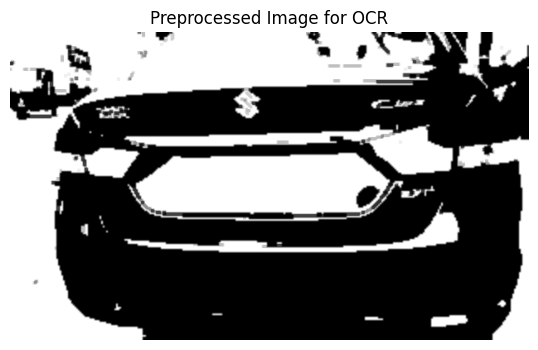

In [43]:
import cv2
import pytesseract
import matplotlib.pyplot as plt

# Tesseract path for Windows
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load image (raw path format)
image_path = r"E:\ML Projects\number plate detection\image1.png"
image = cv2.imread(image_path)

# Step 1: Convert to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply Bilateral Filter (denoising while keeping edges sharp)
filtered = cv2.bilateralFilter(gray, 11, 17, 17)

# Step 3: Apply Adaptive Threshold or Otsu’s Binarization
_, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 4: Resize the image (improves OCR accuracy)
resized = cv2.resize(thresh, (0, 0), fx=2, fy=2)

# Step 5: Morphological transform to enhance features
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morphed = cv2.morphologyEx(resized, cv2.MORPH_CLOSE, kernel)

# Step 6: OCR with better config
custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
text = pytesseract.image_to_string(morphed, config=custom_config)
cleaned_text = text.strip().replace(" ", "").replace("\n", "")

# Print and Show

# Show preprocessed image used for OCR
plt.figure(figsize=(10, 4))
plt.imshow(morphed, cmap='gray')
plt.title("Preprocessed Image for OCR")
plt.axis('off')
plt.show()


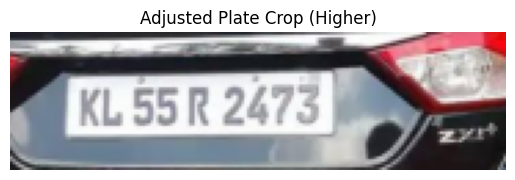

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Plate Text: [KL55R2473]


In [44]:
import cv2
import matplotlib.pyplot as plt
import easyocr

# Image path (Windows raw string)
image_path = r"E:\ML Projects\number plate detection\image1.png"
image = cv2.imread(image_path)

# Check image loaded
if image is None:
    raise FileNotFoundError("Image could not be loaded. Check path.")

# ✅ Final adjusted crop for plate (go higher)
plate_crop = image[60:110, 80:260]  # y1:y2, x1:x2

# Show crop to verify visually
plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
plt.title("Adjusted Plate Crop (Higher)")
plt.axis('off')
plt.show()

# OCR with EasyOCR
reader = easyocr.Reader(['en'])
results = reader.readtext(plate_crop)

# Output result
if results:
    text = results[0][1].strip().replace(" ", "")
    print(f"\nPlate Text: {text}")
else:
    print("\n Plate Text: [No text detected]")


## 